In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2025-05-07 19:27:23.834761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746646043.864261     883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746646043.872778     883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akram24/google-stock-price-train")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/google-stock-price-train


In [3]:
# Load Google stock price dataset
data = pd.read_csv('/kaggle/input/google-stock-price-train/Google_Stock_Price_Train.csv',thousands=',')

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800


In [5]:
# Assume 'Close' is the target column for prediction
data = data[["Close"]]

In [6]:
data.dropna(inplace=True)

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [8]:
# Create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [9]:
sequence_length = 60
X, Y = create_sequences(data_scaled, sequence_length)

In [10]:
# Reshape input to be 3D for RNN [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [11]:
# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [12]:
# Build RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.SimpleRNN(50),
    layers.Dense(1)
])

2025-05-07 19:27:29.097069: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0545 - val_loss: 0.0038
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 5.7443e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 6.3335e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 8.0337e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024 - val_loss: 3.9968e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0010 - val_loss: 4.6012e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019 - val_loss: 4.3627e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.8574e-04 - val_loss: 0.0010
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.8300e-04 - val_loss: 5.4707e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031 - val_loss: 3.8568e-04
Epoch 12/50
27/27 ━━━━━

In [15]:
# Evaluate model
loss = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6066e-04 
Test Loss: 0.0003


In [16]:
# Predict
predicted_stock_price = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [17]:
# Inverse transform predictions
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

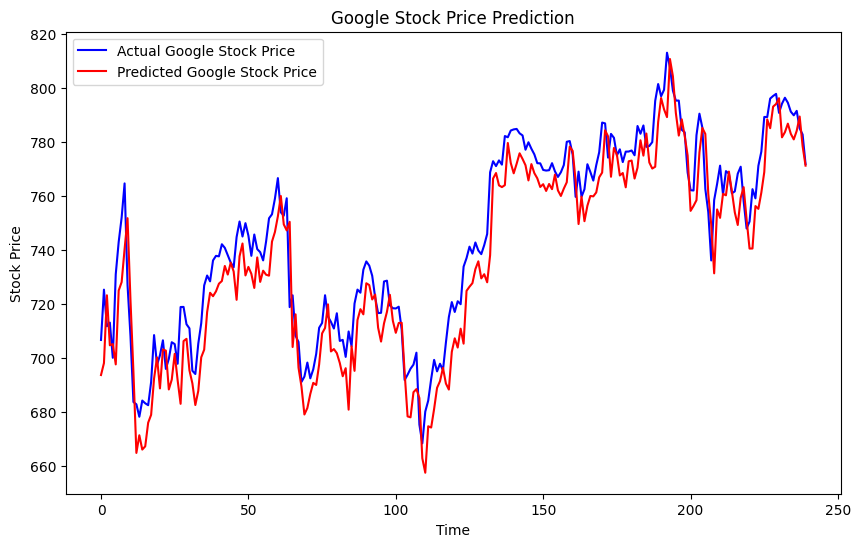

In [18]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Google Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# ### 🧠 Detailed Theoretical Explanation — RNN for Time Series Forecasting (e.g., Stock Prices)

# This code builds a **Recurrent Neural Network (RNN)** using `TensorFlow Keras` to perform **regression** on a time series, such as stock price prediction. Below is the line-by-line theory behind the architecture, compilation, and post-processing steps.

# ---

# ### 📈 Context: Time Series Forecasting

# In stock prediction or any sequential data modeling:

# * The **temporal order** of inputs matters (e.g., yesterday's price affects today's).
# * Data is often reshaped into **samples × timesteps × features** format for sequence models.

# ---

# ### 🏗️ 1. **Model Architecture**

# ```python
# model = keras.Sequential([
#     layers.SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
# ```

# #### 🔹 SimpleRNN Layer (First Layer)

# * **RNN** processes sequential data step-by-step, preserving memory (hidden state) across timesteps.
# * `50` units (neurons): The hidden state dimensionality.
# * `input_shape=(timesteps, features)`:

#   * `timesteps = X_train.shape[1]`: Number of historical time steps in each input sample.
#   * `features = 1`: Univariate input (e.g., closing price only).
# * `return_sequences=True`: Outputs a sequence (not just the final time step), required when stacking RNNs.

# > Each neuron retains **temporal memory**, capturing trends or cycles in time-dependent data.

# ---

# ```python
#     layers.SimpleRNN(50),
# ```

# #### 🔹 Second RNN Layer

# * Another RNN layer with 50 units, stacked on the previous one.
# * Does **not return sequences** (default `return_sequences=False`), so only outputs the **final hidden state**.
# * This final vector is used as input to the Dense layer for prediction.

# > Stacking RNNs increases model capacity and enables learning more complex temporal relationships.

# ---

# ```python
#     layers.Dense(1)
# ])
# ```

# #### 🔹 Output Layer

# * Fully connected layer with 1 neuron → outputs a **single real-valued prediction** (e.g., the next stock price).
# * No activation function is used (linear output) since this is a **regression problem**, not classification.

# ---

# ### ⚙️ 2. **Model Compilation**

# ```python
# model.compile(optimizer='adam', loss='mean_squared_error')
# ```

# * **Optimizer: `adam`**:

#   * Combines momentum and adaptive learning rates.
#   * Suitable for non-stationary objectives like stock prices.

# * **Loss: `mean_squared_error (MSE)`**:

#   * Common regression loss function.
#   * Measures average squared difference between actual and predicted values.
#   * Penalizes large errors more heavily.

# > MSE ensures continuous-valued outputs are optimized toward ground-truth values.

# ---

# ### 🔄 3. **Inverse Scaling of Predictions**

# ```python
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
# y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))
# ```

# #### Why Scaling and Inverse Transform?

# * **scaler** (e.g., `MinMaxScaler`) was used during preprocessing to normalize input values to a fixed range (like 0–1).

# * Neural networks learn better on scaled data, especially in time series with high volatility.

# * After prediction, to interpret results in real-world terms (e.g., actual stock price), you must **reverse the normalization**.

# * `reshape(-1, 1)`: Required because `scaler.inverse_transform()` expects a 2D array of shape `(n_samples, n_features)`.

# > Without inverse scaling, predictions are in normalized space and not directly comparable to real stock prices.

# ---

# ### ✅ Summary

# | Component            | Purpose                                                                    |
# | -------------------- | -------------------------------------------------------------------------- |
# | `SimpleRNN`          | Learns from sequential temporal data using hidden memory                   |
# | `return_sequences`   | Ensures intermediate RNN layers return full sequence, not just final state |
# | `Dense(1)`           | Outputs one real value (e.g., next day's price)                            |
# | `mean_squared_error` | Optimizes continuous output prediction by minimizing average error         |
# | `inverse_transform`  | Converts scaled predictions back to actual price range for interpretation  |

# Let me know if you'd like to visualize predictions vs. actual or integrate LSTM instead of RNN for better long-term dependencies.
